## House Prices: Advanced Regression Techniques

### Ross MacLean Workings

The dataset selected for this project was obtained from Kaggle's current list of open competitions (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). This competition uses the Ames Housing Dataset compiled by Dean De Cock.

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.  With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.  The following workbook documents our team's process in full - from exploratory data analysis, to preprocessing, model selection and evaluation.

In [2]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Preprocessing and stats libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy import stats

# SK-learn libraries for regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import LassoLarsIC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

# SK-learn libraries for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [4]:
# Read in the housing train data
train = pd.read_csv('../Data/train.csv', index_col=0)
train.reset_index(drop=True, inplace=True)

# Read in the test data
test = pd.read_csv('../Data/test.csv', index_col=0)

# Shapes of datasets
print('Train data:', np.array(train).shape)
print('Test data:', np.array(test).shape)

Train data: (1460, 80)
Test data: (1459, 79)


### Missing Values

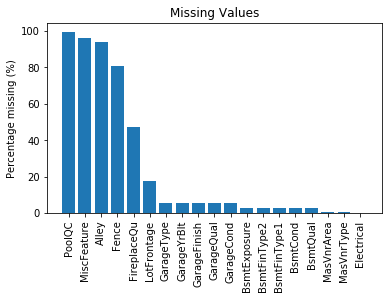

In [5]:
def plot_missing(train=train):
    '''Plot all features with missing values. Accepts
    dataframe as input. Displays bar graph showing
    percentage of missing values by feature.
    '''
    # Calculate missing value counts
    missing = train.isnull().sum()
    missing = pd.DataFrame(missing[missing > 0])

    # Rename and sort counts
    missing.columns = ['count']
    missing.sort_values(by='count', ascending = False, inplace = True)

    # Percentage missing
    missing['percent_missing'] = missing['count'] / len(train.index) * 100

    # Plot missing counts
    fig, ax = plt.subplots(figsize = (6,3.5))
    plt.bar(missing.index, missing['percent_missing'])
    plt.title('Missing Values')
    plt.ylabel('Percentage missing (%)')

    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        
plot_missing()

In [6]:
def return_variable_types(data=train):
    '''Divide dataset columns into qualitative and quantitative array.
    Accepts training data as an input.  Returns a list containing
    list elements of qualitative and quantitative feature names.
    '''
    # Group variables by type
    qualitative = [var for var in data.columns if np.dtype(data[var]) == 'object'].copy()
    quantitative = [var for var in data.columns if np.dtype(data[var]) != 'object'].copy()
    
    return qualitative, quantitative

In [7]:
def replace_missing(data=train):
    '''Replace missing values for qualitative and quantitative
    variables accordingly. Accepts dataframe as an input. 
    Outputs a new dataset with missing values replaced.
    '''

    # Group variables by type
    qualitative, quantitative = return_variable_types(data=data)

    # Identify missing values
    missing = data.columns[data.isnull().any()]

    # Replace with appropriate value according to type
    for col in missing:
        if col in qualitative:
            data[col] = data[col].fillna('None')
        elif col in quantitative:
            data[col] = data[col].fillna(0)      
    return data

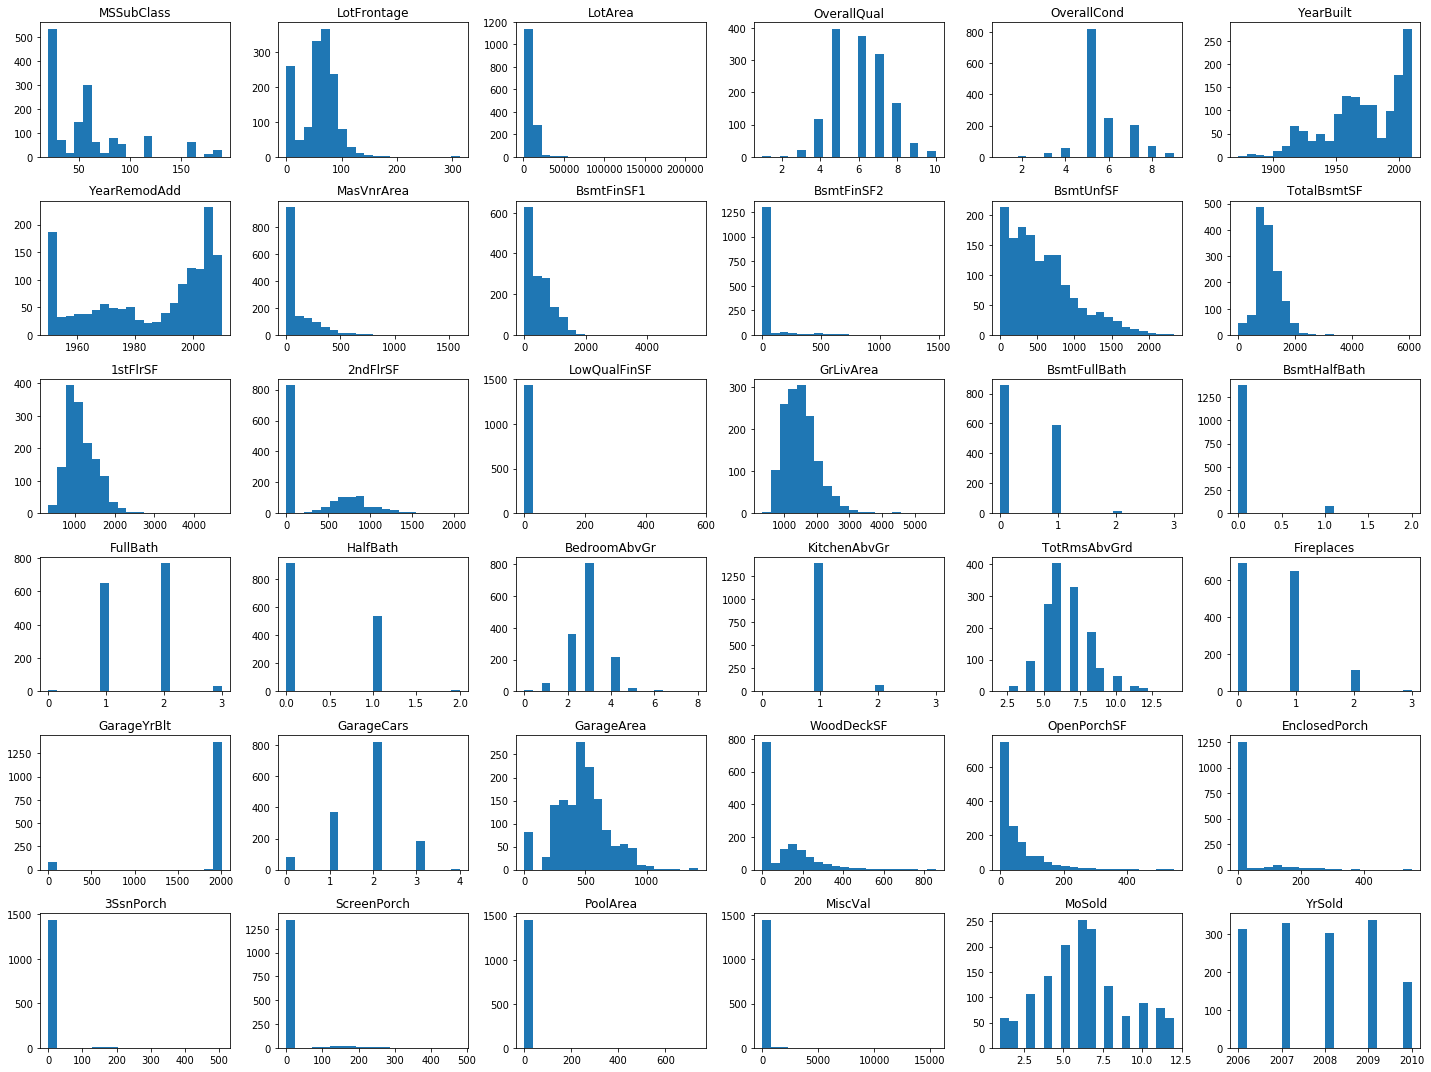

In [8]:
def plot_distribution_quants(train=train):
    '''Plot the distributions of all quantitative variables
    contained in the raw training data.'''

    # Replace missing for train
    train_data = replace_missing(train)

    # Plot distributions of quantitative variables 
    fig, axes = plt.subplots(6,6, figsize = (20,15)) 
    quantitative = return_variable_types(data=train)[1][:-1]
    
    # Loop through each column
    for i, col in enumerate(quantitative):
        
        # Unravel axes and plot
        ax = axes.ravel()[i]
        ax.set_title(col)
        ax.hist(train_data[col], bins=20, density=False)

    fig.tight_layout()
    
plot_distribution_quants()

### Correlations

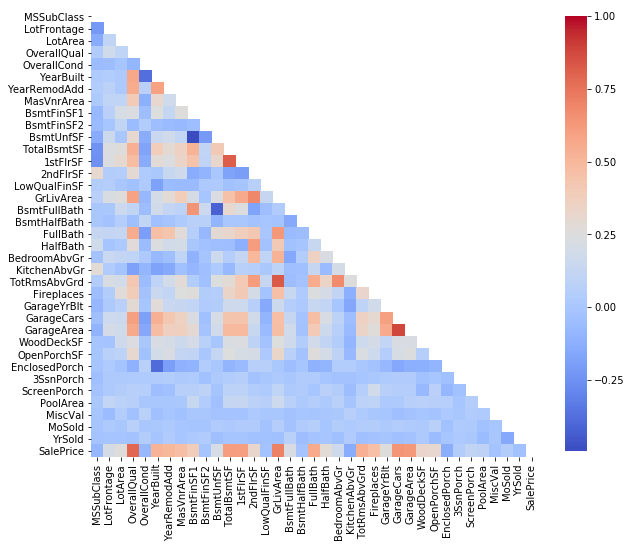

In [9]:
def correlation_matrix(train=train):
    '''Plot correlation matrix for dataset. Accepts
    dataframe as input. Displays upper triangular
    heat map of correlations.
    '''  
    # Create correlation matrix
    corr = train.corr()

    # Define figure size
    plt.rcParams['figure.figsize'] = (10, 10)

    # Mask upper triangle
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    # Plot heapmat
    sns.heatmap(corr, mask=mask, square=True, cmap='coolwarm', cbar_kws={"shrink": 0.8})
    
correlation_matrix()   

The correlation plot shows there are a number of variables that are highly correlated, e.g. Overall Quality and Sale Price.  The extent to which the different variables are correlated will need to be taken into consideration when selecting the appropriate regression model.  For instance, we'll want to avoid a high degree of multicollinearity in order to minimize the bias with our model.

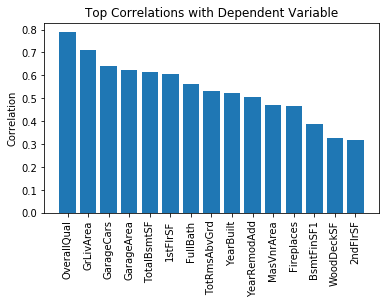

In [10]:
def plot_top_correlations(train=train, n=15):
    '''Plot the top n features that are positively correlated
    with sales price.  Accepts inputs of dataframe and integer
    of top n features to display.  Outputs bar graph of top n
    features by correlation strength.
    '''
    # SalePrice correlations
    corr = train.corr()
    saleprice_corr = pd.DataFrame(corr.loc[['SalePrice'], :].unstack())

    # Reformat df and sort
    saleprice_corr.rename(columns= {0: 'SalePrice'}, inplace = True)
    saleprice_corr.reset_index(level=1, drop=True, inplace=True)
    saleprice_corr.sort_values(by='SalePrice', ascending = False, inplace = True)

    # Top 15 variables most strongly correlated with SalePrice
    saleprice_top_15 = saleprice_corr.iloc[1:n+1, :]
    
    # Plot top correlations
    fig, ax = plt.subplots(figsize = (6,3.5))
    plt.bar(saleprice_top_15.index, saleprice_top_15['SalePrice'])
    plt.title('Top Correlations with Dependent Variable')
    plt.ylabel('Correlation')

    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

plot_top_correlations()

The 15 variables displayed above are those most strongly correlated with SalePrice, our dependent variable.  It's worth noting that some of thse variables are highly correlated with one another (e.g. GarageCars/GarageArea, GrLivArea/TotRmsAbvGrd) and so such pairings should be avoided when specifying the linear regression model so as not to confound results.

### The Dependent Variable - Sale Price

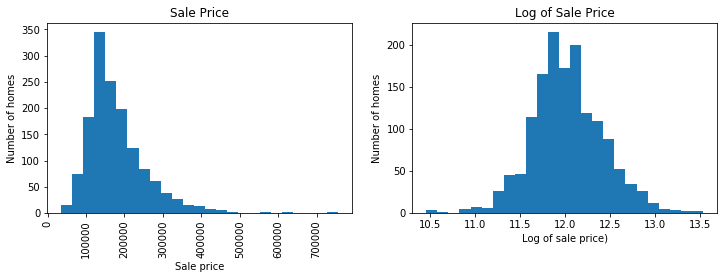

In [11]:
def plot_sale_price(train=train):
    '''Plots the distribution of sales prices (dependent variable).
    Accepts dataframe as input.  Displays distribution of sales
    prices (untransformed) and transformed logarithmically.
    '''
    # Define figure
    fig, axes = plt.subplots(1,2, figsize = (12,3.5))

    # Histogram of sale price
    axes[0].hist(train.SalePrice, bins=25)
    axes[0].set_title('Sale Price')
    axes[0].set_xlabel('Sale price')
    axes[0].set_ylabel('Number of homes')

    # Rotate x labels
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

    # Histogram of log(sale price) 
    axes[1].hist(np.log(train.SalePrice), bins=25)
    axes[1].set_title('Log of Sale Price')
    axes[1].set_xlabel('Log of sale price)')
    axes[1].set_ylabel('Number of homes')

plot_sale_price()

In [12]:
print('Descriptive stats for sale price:')
pd.DataFrame(round(train.SalePrice.describe(),2))

Descriptive stats for sale price:


,SalePrice
count,1460.0
mean,180921.2
std,79442.5
min,34900.0
25%,129975.0
50%,163000.0
75%,214000.0
max,755000.0


### Combine Datasets and Replace Missing Values

In [13]:
def create_full_dataset(train=train, test=test):
    '''Combine train and test data into a full dataset to enable
    transformations to be applied more easily. Accepts inputs
    of train data and test data.  Outputs a full dataset with
    all features, minus the dependent variable (sales price).
    '''
    # Create full data without SalePrice
    full_data = pd.concat((train.loc[:, train.columns != 'SalePrice'], test)).reset_index(drop=True)

    # Replace with appropriate value according to type
    full_data = replace_missing(data=full_data)  
    return full_data.copy()

### Label Encoding

In [14]:
def label_encoder(full_data, columns):
    '''Label encode specified dataframe columns. Accepts
    inputs of pandas dataframe and columns to be encoded.
    Outputs a label encoded data frame.
    '''
    # Label encode all qualitative variables
    for col in columns:
        label_encoder = LabelEncoder()
        label_encoder.fit(list(full_data[col].values)) 
        full_data[col] = label_encoder.transform(list(full_data[col].values))
    return full_data

### One Hot Encoding

In [15]:
def one_hot_encoder(full_data, qualitative, quantitative):
    '''One hot encodes specified dataframe columns. Accepts
    inputs of pandas dataframe and columns to be encoded.
    Outputs a one hot encoded data frame.
    '''
    encoded = full_data[quantitative]
        
    # One hot encode all qualitative variables
    for col in qualitative:
        dummies = pd.get_dummies(full_data[col], prefix=col, sparse=False, drop_first=False)
        encoded = pd.concat([encoded, dummies], axis=1)
    return encoded

### Split the Data

In [16]:
def split_full_dataset(full_data, train=train):
    '''Splits the full dataset into required component parts
    for model training/testing.  Accepts inputs of full_data
    and train data. Outputs dataframes of train_data,
    train_labels, dev_data dev_labels, test_data.
    '''
    # Cut point for train/test post feature engineering
    cut = train.shape[0]
    
    # Recreate train and test sets
    train_data = full_data[:cut]
    y_label = list(train.loc[:, 'SalePrice'])
    train_data.loc[:, 'SalePrice'] = y_label
    test_data = full_data[cut:]

    # Random splits for train and dev sets
    train_set = train_data.sample(frac=0.8, random_state=0)
    dev_set = train_data.drop(train_set.index)

    # Select specified features for each dataset
    train_data, train_labels = train_set.loc[:, train_set.columns != 'SalePrice'], train_set.loc[:, 'SalePrice']
    dev_data, dev_labels = dev_set.loc[:, dev_set.columns != 'SalePrice'], dev_set.loc[:, 'SalePrice']
    
    return train_data, train_labels, dev_data, dev_labels, test_data

In [17]:
def root_mean_squared_error(y_value, y_predict):
    '''Calculate the root mean square error (RMSE). Accepts
    inputs of actual y value and predicted y value. Returns
    the RMSE as a float.
    '''
    return np.sqrt(mean_squared_error(y_value, y_predict))

### Transformations

In [18]:
def transform_data(train=train, test=test, encoder='none'):
    
    full_transformed = create_full_dataset(train=train, test=test)
    
    #full_transformed['MSSubClass'] = full_transformed['MSSubClass'].astype(str)
    #full_transformed['OverallCond'] = full_transformed['OverallCond'].astype(str)
    #full_transformed['OverallQual'] = full_transformed['OverallQual'].astype(str)
    #full_transformed.drop(columns='Street', inplace=True)
    
    # Encode transformed dataset
    qualitative = [var for var in full_transformed.columns if np.dtype(full_transformed[var]) == 'object']
    quantitative = [var for var in full_transformed.columns if np.dtype(full_transformed[var]) != 'object']
    
    if encoder == 'label_encoder':
        full_transformed = label_encoder(full_transformed, qualitative)
    elif encoder == 'onehot_encoder':
        full_transformed = one_hot_encoder(full_transformed, qualitative, quantitative)
    else:
        full_transformed
        
    return full_transformed

### Encoding the Data

In this project, regressors are being used to predict the output variable, sale price.  Therefore it is necessary to transform all strings to suitable numerical values before passing the dataset to the regressor.  This transformation can be done using either label encoding or one hot encoding.  Unfortunately, it seems it is not possible to incorporate label encoding or one hot encoding as a preprocessing step in our pipeline.  As such it is necessary to encode our dataset before passing to our regression model.

Label encoding transforms all strings values to an integer, e.g. Neighborhood's of NorthAmes, OldTown and Sawyer are transformed to 1, 2 and 3 respectively.  The issue here is that their numerical representations may be interpreted as ordinal when in fact there's no ordinal relationship is present.  For instance, our model may incorrectly interpret that as neighborhood number increases, so too does sale price.

An alternative option is to apply one hot encoding which effectively creates binary flags for each values.  Reusing using the previous example, three new variables would be created to represent the 3 neighborhoods.  While this approach mitigates against the issue of creating fictitious ordinal relationships, it greatly increases our feature space.

## Model Building

### Basic Linear Model

In [19]:
def linear_regression(train=train, test=test, encoder='none'):
    '''Fit linear regression model, predict dependent variable and
    display scatter plot with regression line and residual plot.
    Accepts inputs of full_data and encoding type (none, label or
    one hot). Returns model accuracy, RMSE and plots.
    '''
    full_data = transform_data(train=train, test=test, encoder=encoder)

    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    
    # Log of sales price
    train_labels_log = np.log(train_labels)
    dev_labels_log = np.log(dev_labels)

    # Fit the linear regression model
    lr = LinearRegression()
    lr.fit(train_data, train_labels_log)
    predict_dev_log = lr.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # Plot predicted vs. actual values
    fig, axes = plt.subplots(1,2,figsize = (11.5,4))
    
    # Calculate regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(dev_labels, predict_dev_value)
    line_x = np.arange(dev_labels.min(), dev_labels.max())
    line_y = slope*line_x + intercept
    
    # Plot data and regression line
    axes[0].scatter(predict_dev_value, dev_labels)
    axes[0].plot(line_x, line_y, color='red', linestyle = '--')

    axes[0].set_title('Linear regression: Actual vs. Predicted')
    axes[0].set_xlabel('Predicted price')
    axes[0].set_ylabel('Actual price')
    
    # Plot residuals
    axes[1].scatter(predict_dev_value, predict_dev_value - dev_labels, color='black', s=20)
    axes[1].hlines(y=0, xmin= 0, xmax=500000, colors='red')
    
    axes[1].set_title('Residuals: Variance of Fitted Values')
    axes[1].set_xlabel('Predicted price')
    axes[1].set_ylabel('Variance from actual')
    axes[1].set_ylim(-160000,150000)
    
    fig.tight_layout()
    
    # R^2 and root mean squared error
    print('Features: {}'.format(full_data.shape[1]))
    print('Accuracy: {:.4f}'.format(lr.score(dev_data, dev_labels_log)))
    print('RMSE: {:.4}'.format(root_mean_squared_error(dev_labels_log, predict_dev_log)))

Linear regression with label encoding
Features: 79
Accuracy: 0.8761
RMSE: 0.1317


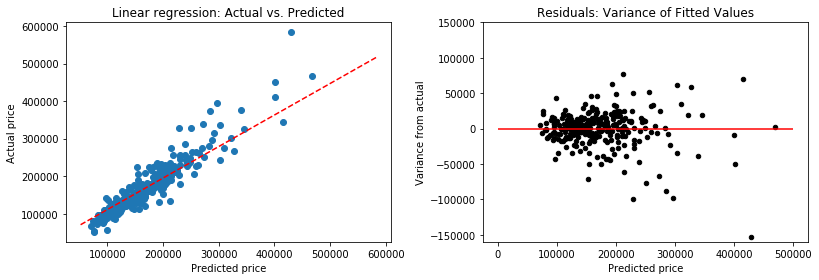

In [20]:
print('Linear regression with label encoding')
linear_regression(encoder='label_encoder')

The basic linear regression model with label encoding acheived an R^2 of 0.8761 when predicting on the dev data.  It should be noted however that as house price increases, there's a tendancy for the predicted value to exhibit greater variance from the true sale price.  This is confirmed by the above residual plot, revealing the presence of non-constant variance, i.e. heteroskedasticity.

Linear regression with one hot encoding
Features: 310
Accuracy: 0.9159
RMSE: 0.1085


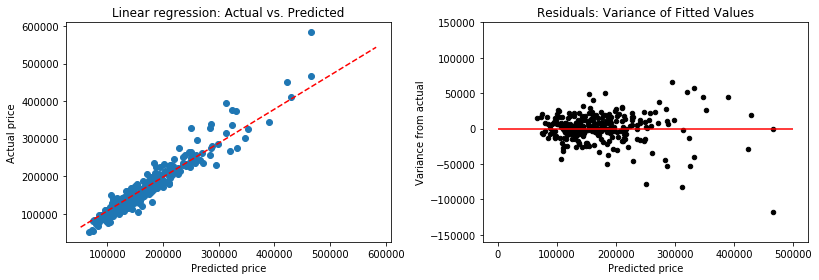

In [21]:
print('Linear regression with one hot encoding')
linear_regression(encoder='onehot_encoder')

The linear regression model with one hot encoding acheived an R^2 of 0.9159, representing an increase of 0.0407 compared to label encoding.  This improvement can be attributed to the fact that one hot encoding ensures that the linear regression model will not interpret any false ordinal relationships in the data (as is the case with label encoding) however it comes at a price.  The feature space has now increased our feature space almost 4-fold, from 79 to 310 features, making interpretation of results more challenging.  

The residual plot also shows tendancy toward greater variance as house price increases (non-constant variance), again indicating that our modeling process may benefit from further preprocessing (e.g. transforming features, removing outliers) and regularization.

As we add more features to our model, it's complexity increases which in turn increases variance and reduces bias.  This makes the model more prone to overfitting.  The goal is to find the optimal point where the decrease in bias is equal to the increase in varaince.  To achieve this it is necessary to either reduce model complexity or introduce regularization.  The next section will look at the effect of Lasso Regression, which uses L1 regularization to select features with the greatest coefficients, on the predictive power.

### Lasso Regression

Lasso Regression performs L1 regularization to minimize the Residual Sum of Squares (RSS) plus the sum of absolute value of the magnitude of the coefficient weights.  The effect is that the magnitude of the coefficients shrinks as alpha is increased, thereby reducing the featurs space.  It is an effective ways to select those features that best describe the variance of the dependent variable, in this case Sale Price.  Our data also contains a number of highly correlated variables, and lasso regression accounts for this by arbitrarily select one of the features and setting the coefficient size to zero for all others.

Lasso Regression
Best alpha: 0.0001
Features: 56
R^2: 0.8795
RMSE: 0.1299


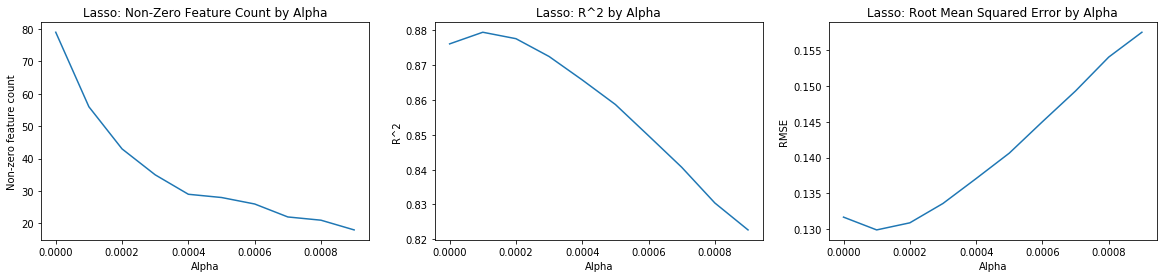

In [22]:
def lasso_regression(alphas, encoder='none',train=train, test=test):
    '''Fit lasso regression model, make predictions and
    display results. Accepts input of full_data and
    returns (prints) model accuracy and RMSE.
    '''
    # Lasso with alpha=0 is the same as OLS.
    # Accuracy should match basic linear regression (it does).

    full_data = transform_data(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Parameters
    alphas = alphas
    feature_count = []
    r2 = []
    rmse = []

    for alpha in alphas:

        # Lasso - fit the model
        lasso = Lasso(alpha=alpha, normalize=True)
        lasso.fit(train_data, train_labels_log)

        # Make prediction
        predict_dev_log = lasso.predict(dev_data)
        predict_dev_value = np.exp(predict_dev_log)

        # Append accuracy/results
        r2.append(lasso.score(dev_data, dev_labels_log))
        rmse.append(root_mean_squared_error(dev_labels_log, predict_dev_log))

        # Feature coefficients
        features = train_data.columns
        df = pd.DataFrame({'feature': features, 'coef': lasso.coef_})
        df.sort_values(by='coef', inplace=True)
        trimmed_features = df.loc[df['coef'] != 0]
        
        # Number of non-zero features
        feature_count.append(len(list(trimmed_features['feature'])))
    
    # Zip scores
    outputs = tuple(zip(rmse, r2, feature_count))

    # Dictionary of results
    results = dict(zip(alphas, outputs))
    best = min(results, key=results.get)
    print('Lasso Regression')
    print('Best alpha:', best)
    print('Features: {}'.format(results[best][2]))
    print('R^2: {:.4f}'.format(results[best][1]))
    print('RMSE: {:.4f}'.format(results[best][0]))
    
    # Plot coefficients
    fig, axes = plt.subplots(1,3,figsize = (20,4))
       
    # Feature count
    axes[0].plot(alphas, feature_count)
    axes[0].set_title('Lasso: Non-Zero Feature Count by Alpha')
    axes[0].set_xlabel('Alpha')
    axes[0].set_ylabel('Non-zero feature count')
     
    # R^2
    axes[1].plot(alphas, r2)
    axes[1].set_title('Lasso: R^2 by Alpha')
    axes[1].set_xlabel('Alpha')
    axes[1].set_ylabel('R^2')
        
    # RMSE
    axes[2].plot(alphas, rmse)
    axes[2].set_title('Lasso: Root Mean Squared Error by Alpha')
    axes[2].set_xlabel('Alpha')
    axes[2].set_ylabel('RMSE')
    
lasso_regression(alphas=np.arange(0,0.001,0.0001), encoder='label_encoder')

The best alpha (n=0.0001) resulted in an R^2 of 0.8795, meaning the 56 features (independent variables) selected explain close to 88% of the variance observed in the dependent variable Sales Price.  While this represents a slight decrease in predictive power compared to the full dataset OneHotEncoded (decrease in R^2 of 0.0365), the feature space has been reduced drastically from 310 to 56 features.

Lasso Regression
Alpha: 0.0007
Accuracy: 0.8407
RMSE: 0.1493


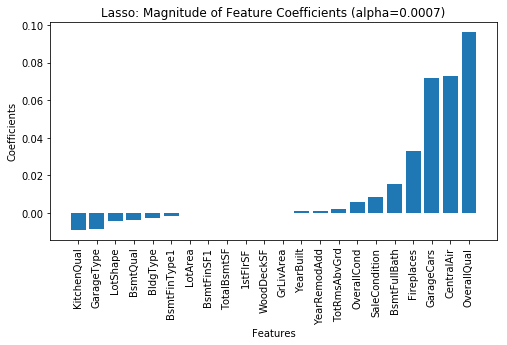

In [23]:
def lasso_coefficients(alpha, encoder='none', train=train, test=test):
    '''Fit lasso regression model, make predictions and
    display results. Accepts input of full_data and
    returns (prints) model accuracy and RMSE.
    '''
    # Lasso with alpha=0 is the same as OLS.
    # Accuracy should match basic linear regression (it does).

    full_data = transform_data(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Lasso - fit the model
    lasso = Lasso(alpha=alpha, normalize=True)
    lasso.fit(train_data, train_labels_log)
    
    # Make prediction
    predict_dev_log = lasso.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)
    
    # R^2 and root mean squared error
    print('Lasso Regression')
    print('Alpha:', alpha)
    print('Accuracy: {:.4f}'.format(lasso.score(dev_data, dev_labels_log)))
    print('RMSE: {:.4}'.format(root_mean_squared_error(dev_labels_log, predict_dev_log)))
    
    # Feature coefficients
    features = train_data.columns
    df = pd.DataFrame({'feature': features, 'coef': lasso.coef_})
    df.sort_values(by='coef', inplace=True)
    trimmed_features = df.loc[df['coef'] != 0]

    # Plot coefficients
    fig, ax = plt.subplots(figsize = (8,4))
    plt.bar(trimmed_features['feature'], trimmed_features['coef'])

    plt.title('Lasso: Magnitude of Feature Coefficients (alpha={})'.format(alpha))
    plt.ylabel('Coefficients')
    plt.xlabel('Features')

    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        
lasso_coefficients(alpha=0.0007, encoder='label_encoder')

Performing L1 regularization, the feature space decreases as alpha increases.  With an increased alpha of 0.0007 the feature space has now reduced to 22 features and the resulting feature coefficients have been plotted above.  The features found to best explain the variance in Sales Price were:

1. Overall Quality
2. Central Air
3. Garage Cars
4. Fireplaces
5. Basement Full Bath
6. Sale Condition
7. Overall Condition

Intuitively, many of these features would be expected to have a positive effect of Sale Price, e.g. Overall Quality. That said, the number of fireplaces and the prescence of central air appear to be stronger predictors of Sale Price than one may otherwise expect.  Additionally, Kitchen Quality appears to have a negative effect on Sale Price which seems counter-inuitive.  Nonetheless, Lasso Regression with L1 regulatization results in a model with improved interpretability with a modest reduction in predictive power (R^2: , compared to the baseline Linear Regression model  

As mentioned, lasso regression accounts for highly correlated variables by setting the magitude of one of such features to zero and omitting from the model.  To confirm this, the table below contains pairs of features with high degrees of multicollinearity, all of which are strong predictors of Sale Price. Following L1 regularization, it can be observed that only one feature within each highly correlated pair has been retained in the above feature plot.

In [24]:
def multicollinearity(n=5, train=train):
    '''Identify features that are highly correlated
    Accepts inputs of top n features to display and
    return a data frame of highly correlated pairs.
    '''
    # Unstack correlation matrix
    corr = pd.DataFrame(train.corr().unstack().sort_values().drop_duplicates())

    # Rename columns
    corr.reset_index(inplace=True)
    corr.columns = ['feature1', 'feature2','correlation']
    corr.sort_values(by='correlation', ascending=False, inplace=True)

    # Remove correlations with sale price
    corr = corr[corr['feature1'] != 'SalePrice']
    corr = corr[corr['feature2'] != 'SalePrice']

    # Show top n
    return corr.iloc[1:n+1]

multicollinearity()

,feature1,feature2,correlation
665,GarageCars,GarageArea,0.882475
664,TotRmsAbvGrd,GrLivArea,0.825489
663,1stFlrSF,TotalBsmtSF,0.819530
660,2ndFlrSF,GrLivArea,0.687501
659,TotRmsAbvGrd,BedroomAbvGr,0.676620


### Gradient Boosting

Gradient boosting is an ensemble model that use boosting methods to optimize the loss function (squared error) of the generalized model.  Boosting methods operate in a stage-like fashion, and in gradient boosting a series of weak learners, typically decision tress, are created that iteratively build upon the preceeding learner to optimize the loss function in the final model. For instance, an initial weak learner is created that predicts Sale Price using some constant, in the next iteration a new weaker learner is created that is fitted to the residuals of the previous learner and so on and so forth.  The result is an ensemble model that minimizes the loss function using a gradient descent algorithm, hence the name Gradient Boosting.

The following hyperparameters will be tuned for model optimization:
 - n-estimtors: the number of weak learners (estimators) that will be used in the iterative boosting process
 - learning rate: shrinks the contribution of each tree.  Smaller learning rates are associated with improved generalizability but come at computational cost, as lower learning rates require greater iterations.

Gradient Boosting Regression
N-estimators: 360
Accuracy: 0.9091
RMSE: 0.1128


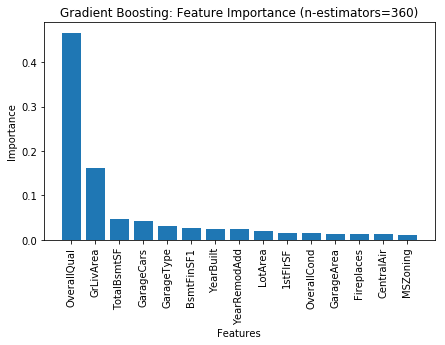

In [25]:
def gradient_boosting(n_estimators=100, learning_rate=0.1, encoder='none', train=train, test=test):
    
    full_data = transform_data(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)
    
    # Gradient Boosting - fit the model
    gbm = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
    gbm.fit(train_data, train_labels_log)

    # Make predictions
    predict_dev_log = gbm.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)
    
    # Feature importance
    train_trim = train.loc[:, train.columns != 'SalePrice']
    importance = pd.DataFrame({'feature': train_trim.columns, 'importance': gbm.feature_importances_})
    importance.sort_values(by='importance', ascending=False, inplace=True)
    trimmed_features = importance.loc[importance['importance'] > 0.01]

    # Plot feature importance
    fig, ax = plt.subplots(figsize = (7,4))
    plt.bar(trimmed_features['feature'], trimmed_features['importance'])

    plt.title('Gradient Boosting: Feature Importance (n-estimators={})'.format(n_estimators))
    plt.ylabel('Importance')
    plt.xlabel('Features')
    
    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        
    # R^2 and root mean squared error
    print('Gradient Boosting Regression')
    print('N-estimators: {}'.format(n_estimators))
    print('Accuracy: {:.4f}'.format(gbm.score(dev_data, dev_labels_log)))
    print('RMSE: {:.4}'.format(root_mean_squared_error(dev_labels_log, predict_dev_log)))
    
gradient_boosting(n_estimators=360, learning_rate=0.06, encoder='label_encoder')

Gradient Boosting Regression 

[add discussion about features]

In gradient boosting each feature is assigned a measure of importance and the total importance for all fitted features sums to 1.  Overall Quality has an importance of nearly 0.5, meaning that this single feature carries the same importance (in terms of ability to estimate Sale Price) as the remaining 78 features added together.

### Voting Regression

In [36]:
def voting_regression(encoder='none', train=train, test=test):
    
    full_data = transform_data(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Multiple regression models for voting
    gbm = GradientBoostingRegressor(n_estimators=360, learning_rate=0.06)
    rf = RandomForestRegressor(n_estimators=300)
    lr = LinearRegression()
    vreg = VotingRegressor([('gb', gbm), ('rf', rf), ('lr', lr)])

    # Fit models
    gbm.fit(train_data, train_labels_log)
    rf.fit(train_data, train_labels_log)
    lr.fit(train_data, train_labels_log)
    vreg.fit(train_data, train_labels_log)
    
    # Make predictions
    predict_dev_log = vreg.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    print('Voting Regression using GB, RF and LR')
    print('Encoding:', encoder)
    print('Accuracy: {:.4f}'.format(vreg.score(dev_data, dev_labels_log)))
    print('RMSE: {:.4}'.format(root_mean_squared_error(dev_labels_log, predict_dev_log)))
    
voting_regression(encoder='label_encoder')

Voting Regression using GB, RF and LR
Encoding: label_encoder
Accuracy: 0.9071
RMSE: 0.1141


In [37]:
voting_regression(encoder='onehot_encoder')

Voting Regression using GB, RF and LR
Encoding: onehot_encoder
Accuracy: 0.9210
RMSE: 0.1052


### Model Optimization with Grid Search

In [52]:
def gboost_grid_search(train=train, test=test):
    '''Fit GridSearchCV using lasso regression for various
    alpha. Accepts input of full_data and returns (prints)
    the best model score and corresponding alpha.
    '''
    full_data = transform_data(encoder='label_encoder')
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Parameters
    model = GradientBoostingRegressor()
    param_grid = {'n_estimators': np.arange(200,500,10),
                  'learning_rate': np.arange(0.01,0.1,0.05)}
    
    # Fit grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_search.fit(train_data, train_labels_log)

    # Make predictions
    predict_dev_log = grid_search.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # summarize the results of the grid search
    print('Gradient Boosting Regression')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    print('Best estimator: {}'.format(grid_search.best_estimator_.n_estimators))
    print('Best learning rate: {}'.format(grid_search.best_estimator_.learning_rate))

gboost_grid_search()

Gradient Boosting Regression
Best score: 0.890
Best estimator: 230
Best learning rate: 0.060000000000000005


In [ ]:
def lasso_grid_search(train=train, test=test):
    '''Fit GridSearchCV using lasso regression for various
    alpha. Accepts input of full_data and returns (prints)
    the best model score and corresponding alpha.
    '''
    full_data = transform_data(encoder='label_encoder')
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Parameters
    model = Lasso(normalize=True)
    param_grid = {'alpha': np.arange(0,0.01,0.0001)}
    
    # Fit grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_search.fit(train_data, train_labels_log)

    # Make predictions
    predict_dev_log = grid_search.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # summarize the results of the grid search
    print('Lasso regression')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    print('Best estimator: {}'.format(grid_search.best_estimator_.alpha))

lasso_grid_search()

In [ ]:
def optimize_regressor(pipe, param_grid, encoder='none', train=train, test=test):
    '''Optimizes regression model using grid search.
    Accepts inputs of pipeline (list of tuples)
    and parameter grid (dictionary of nested lists). 
    Outputs the best parameters and f1 score.
    '''
    full_data = transform_data(encoder=encoder)
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Fit model using GridSearch
    grid_search = GridSearchCV(pipe, param_grid, scoring='r2', cv=3)
    grid_search.fit(train_data, train_labels_log)
    predict_dev_log = grid_search.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)
    
    print('Lasso regression')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    print('Best RMSE: {:.3f}'.format(grid_search.best_score_))
    print('Best alpha:', grid_search.best_params_['est__alpha'])

In [ ]:
def lasso_pipeline():
    '''Create pipeline for lasso regression and find
    optimal parameters using optimize_regressor().
    Outputs best model score and corresponding alpha.
    '''
    # Lasso pipeline
    pipe_lasso = Pipeline([('scale', StandardScaler()),
                           ('est', Lasso(normalize=True))])

    # Parameters for optimization
    param_lasso = {'est__alpha': np.arange(0,0.01,0.0001)}

    # Optimize logistic regression
    optimize_regressor(pipe_lasso, param_lasso, encoder='label_encoder')

lasso_pipeline()